In [14]:
import cv2
import numpy as np

from scipy.signal import find_peaks
from scipy.spatial import distance

import itertools

import matplotlib.pyplot as plt

In [15]:
#定義圖像顯示函式
def show(image):
    plt.imshow(image, cmap="gray")
    plt.xticks([])
    plt.yticks([])

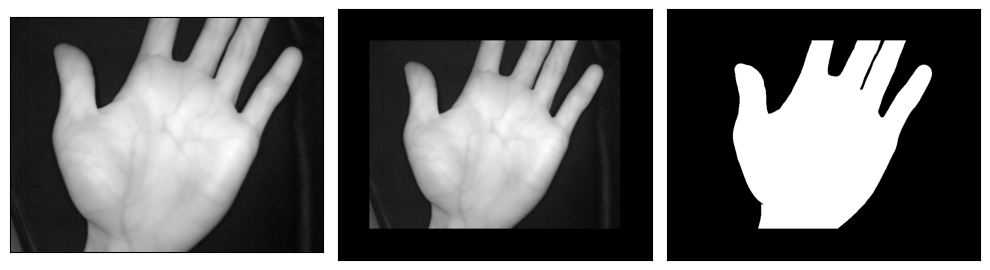

In [16]:
img = cv2.imread("66.png", 0)

h, w = img.shape

#創建新圖像, 並將原圖放在圖像中央, 以利後續影像處理
img2 = np.zeros((h+160, w+160), np.uint8)
img2[80:-80, 80:-80] = img

#圖像二值化, 結合Otsu決定分割閾值
_, thresh = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#找到最大輪廓, 並繪製
contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)
canvas = np.zeros_like(thresh)
cv2.drawContours(canvas, [max_contour], -1, (255), thickness=cv2.FILLED)

plt.figure(figsize=(10, 10))
plt.subplot(131)
show(img)
plt.subplot(132)
show(img2)
plt.subplot(133)
show(canvas)
plt.tight_layout()
plt.show()

In [17]:
#利用空間矩的零階矩與一階矩計算中心的x, y座標
M = cv2.moments(canvas)
x_c = M["m10"] // M["m00"]
y_c = M["m01"] // M["m00"]

print(x_c, y_c)

396.0 322.0


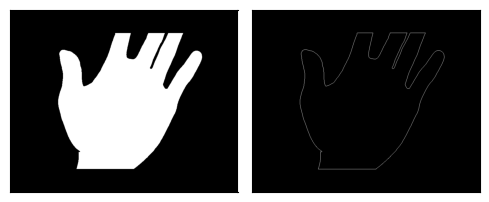

In [18]:
#將數學形態學侵蝕的核心定義為十字形來侵蝕圖像
kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]]).astype(np.uint8)

#侵蝕
erosion = cv2.erode(canvas, kernel, iterations=1)

#邊界 = 侵蝕前圖像 - 侵蝕後圖像
boundary = canvas - erosion

plt.figure(figsize=(5, 5))
plt.subplot(121)
show(erosion)
plt.subplot(122)
show(boundary)
plt.tight_layout()
plt.show()

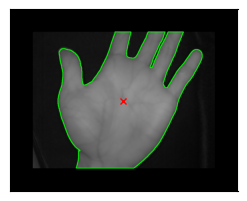

In [19]:
#繪製手掌輪廓
cnt, _ = cv2.findContours(boundary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
img_c = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
cnt = cnt[0]
img_cnt = cv2.drawContours(img_c, [cnt], 0, (0, 255, 0), 2)

plt.figure(figsize=(5, 5))
plt.subplot(121)
plt.plot(x_c, y_c, "rx", markersize=5) #繪製手掌中心
show(img_cnt)
plt.tight_layout()
plt.show()

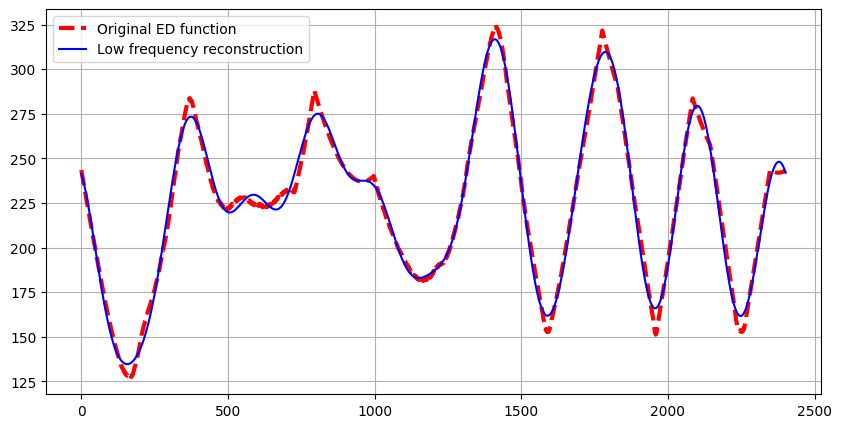

In [20]:
#輪廓點reshape為(-1, 2)矩陣
cnt = cnt.reshape(-1, 2)

#計算每個輪廓點到中心點的歐式距離
dist_c = np.sqrt(np.square(cnt-[x_c, y_c]).sum(-1))

#對距離序列進行快速傅立葉變換
f = np.fft.rfft(dist_c)

#設置截止頻率15
cutoff = 15

#保留低頻部分, 高於截止頻率的分量置0
f_new = np.concatenate([f[:cutoff], 0*f[cutoff:]])

#修改後的傅立葉進行逆變換
dist_c_1 = np.fft.irfft(f_new)

plt.figure(figsize=(10, 5))
plt.plot(dist_c, label="Original ED function", color="r", linewidth="3", linestyle="--")
plt.plot(dist_c_1, label="Low frequency reconstruction", color="b", linestyle="-")
plt.grid()
plt.legend()
plt.show()

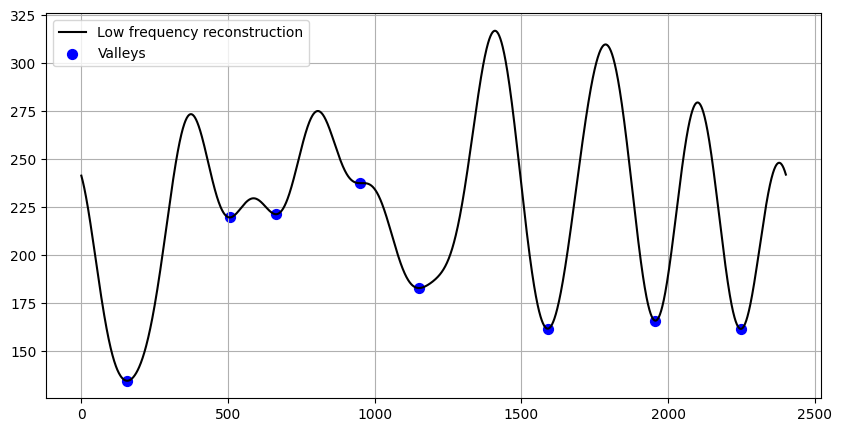

In [21]:
#尋找手掌峰值, 找谷點
valleys, _ = find_peaks(-dist_c_1)

sorted_valleys = sorted(valleys, key=lambda x: cnt[x][0])

#標記谷點, 視覺化
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(dist_c_1, color="black", label="Low frequency reconstruction")
plt.scatter(sorted_valleys, dist_c_1[sorted_valleys], color="blue", s=50, label="Valleys", marker="o")
plt.legend()
plt.show()

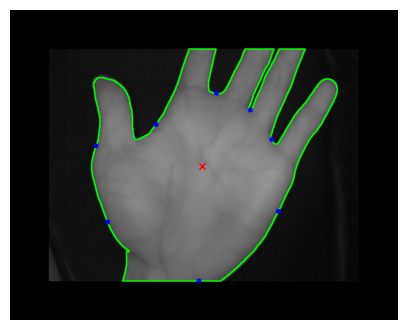

In [22]:
#走訪所有谷點, 視覺化在圖像上
for valley in valleys:
    point = tuple(cnt[valley])
    cv2.circle(img_cnt, point, radius=5, color=(255, 0, 0), thickness=-1)

plt.figure(figsize=(5, 5))
plt.plot(x_c, y_c, "rx", markersize=5)
plt.imshow(cv2.cvtColor(img_cnt, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

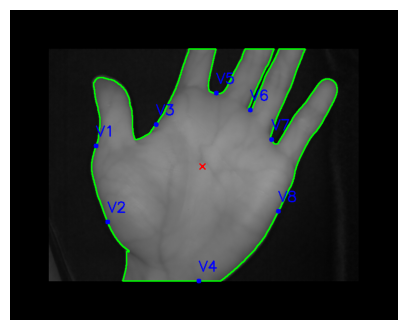

In [23]:
#走訪所有谷點, 標記谷點標號
for i, valley in enumerate(sorted_valleys):
    point = tuple(cnt[valley])
    cv2.circle(img_cnt, point, radius=5, color=(255, 0, 0), thickness=-1)
    label_pos = (point[0], point[1] - 20)
    cv2.putText(img_cnt, f"V{i+1}", label_pos, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    # print(point)

plt.figure(figsize=(5, 5))
plt.plot(x_c, y_c, "rx", markersize=5)
plt.imshow(cv2.cvtColor(img_cnt, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

原始谷點: [(177, 280), (201, 437), (301, 236), (389, 559), (425, 171), (495, 206), (539, 267), (553, 415)]

過濾後谷點: [(177, 280), (201, 437), (301, 236), (389, 559), (425, 171), (495, 206), (539, 267), (553, 415)]

刪除最左及最右谷點: [(201, 437), (301, 236), (389, 559), (425, 171), (495, 206), (539, 267)]

起點: (539, 267) 終點: (425, 171)


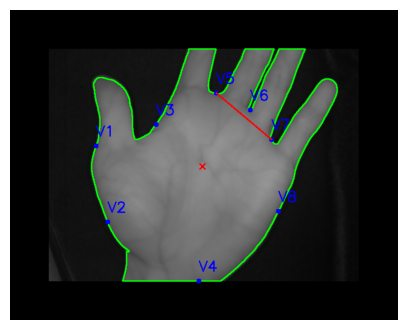

In [24]:
'''
自定義過濾谷點的函式
1.保留點跟點之間歐式距離大於30的谷點 (有時候會有雜訊, 點跟點之間會非常近, 為了避免誤判就過濾掉距離太近的點)
2.刪除最左最右谷點 (最左及最右點有時會跟感興趣的三谷點很近, 這樣會影響後續的ROI提取, 所以刪除最左及最右點)
'''

def filter_points(points, delete_first_last=False):
    filter_points = []
    pre_point = None
    for point in points:
        if pre_point is not None:
            if distance.euclidean(point, pre_point) >= 30:
                filter_points.append(point)
        else:
            filter_points.append(point)
        pre_point = point
        
    if delete_first_last and len(filter_points) >= 2:
        return filter_points[1:-1]
    else:
        return filter_points

valley_points = [tuple(cnt[valley]) for valley in sorted_valleys]
print("原始谷點:", valley_points)

filter_valley_points = filter_points(valley_points)
print("\n過濾後谷點:", filter_valley_points)

filter2_valley_points = filter_points(valley_points, delete_first_last=True)
print("\n刪除最左及最右谷點:", filter2_valley_points)

def total_distance(points):
    return sum(distance.euclidean(points[i], points[i+1]) for i in range(len(points) - 1))

combinations = list(itertools.combinations(filter2_valley_points, 3))

min_combination = min(combinations, key=total_distance)

#找到距離最近的三谷點, 並連線, 以利後續提取ROI
for i in range(3):
    if i == 2:
        start_point = min_combination[i]
        end_point = min_combination[(i+1) % 3]
        cv2.line(img_cnt, start_point, end_point, (0, 0, 255), 2)
        print("\n起點:", start_point, "終點:", end_point)
    
plt.figure(figsize=(5, 5))
plt.plot(x_c, y_c, "rx", markersize=5)
plt.imshow(cv2.cvtColor(img_cnt, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

P1: (425, 171) P2: (539, 267)
旋轉 40.1009° 度
選轉後的P1, P2座標, P1: [389 267] P2: [539 267]
方形四點座標, ux: 389 uy: 317 lx: 539 ly: 467


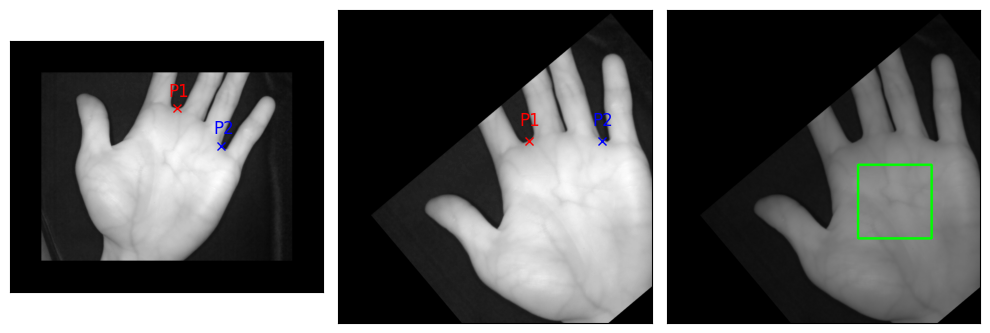

In [25]:
#定義ROI的起點終點
p2, p1 = start_point, end_point
print("P1:", p1, "P2:", p2)

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.plot(p1[0], p1[1], "rx")
plt.plot(p2[0], p2[1], "bx")
plt.text(p1[0] -20, p1[1] - 30, "P1", color="red", fontsize=12)
plt.text(p2[0] -20, p2[1] - 30, "P2", color="blue", fontsize=12)
show(img2)

#旋轉 P1到P2這條線與水平線的夾角
plt.subplot(132)
p1 = np.array(p1)
p2 = np.array(p2)
theta = np.arctan2((p2-p1)[1], (p2-p1)[0]) *180 /np.pi
print("旋轉 {:.04f}\u00b0".format(theta),"度")
R = cv2.getRotationMatrix2D((int(p2[0]), int(p2[1])), theta, 1)
img_r = cv2.warpAffine(img2 , R, (w, h+160))
p1 = (R[:, :2] @ p1 + R[:, -1]).astype(np.int64)
p2 = (R[:, :2] @ p2 + R[:, -1]).astype(np.int64)
print("選轉後的P1, P2座標, P1:", p1, "P2:", p2)
plt.plot(p1[0], p1[1], "rx")
plt.plot(p2[0], p2[1], "bx")
plt.text(p1[0] -20, p1[1] - 30, "P1", color="red", fontsize=12)
plt.text(p2[0] -20, p2[1] - 30, "P2", color="blue", fontsize=12)
show(img_r)

#計算ROI上下左右座標
ux = p1[0]
uy = p1[1] + (p2-p1)[0] // 3
lx = p2[0]
ly = p2[1] + 4 * (p2-p1)[0] // 3
print("方形四點座標, ux:", ux, "uy:", uy,"lx:", lx,"ly:", ly)
img_c = cv2.cvtColor(img_r, cv2.COLOR_GRAY2BGR)
cv2.rectangle(img_c, (lx, ly), (ux, uy), (0, 255, 0), 3)
cv2.imwrite("palm_ROI.png", img_c)

plt.subplot(133)
show(img_c)
plt.tight_layout()
plt.show()

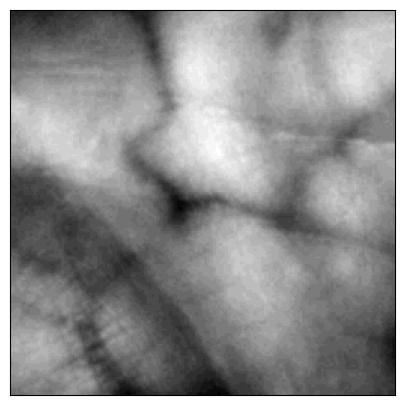

In [26]:
#裁減ROI並resize
roi = img_r[uy:ly, ux:lx]
roi = cv2.resize(roi, (256, 256))

cv2.imwrite("ROI.png", roi)

plt.figure(figsize=(5, 5))
show(roi)